In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pyfume.Clustering import Clusterer
from pyfume.EstimateAntecendentSet import AntecedentEstimator
from pyfume.EstimateConsequentParameters import ConsequentEstimator
from pyfume.SimpfulModelBuilder import SugenoFISBuilder
from pyfume.Tester import SugenoFISTester
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score
from numpy import clip, column_stack, argmax

In [2]:
# Import and clean the data
column_names = ["Clump_Thickness", "Uniformity_of_Cell_Size", "Uniformity_of_Cell_Shape", "Marginal_Adhesion", "Single_Epithelial_Cell_Size", "Bland_Chromatin", "Normal_Nucleoli", "Mitoses", "Something", "Cancer"]
data = pd.read_csv(os.path.abspath('wbco.csv'),names=column_names)
data.head()
rows_with_question_mark = data[data.isin(["?"]).any(axis=1)].index
data = data.drop(rows_with_question_mark)
data = data.astype('int')
data['Cancer'] = data['Cancer'].astype('int')
column_names = column_names[:-1]

# Choose predictors and output
X = data[column_names].values
y = data["Cancer"].values.reshape(-1, 1)

In [3]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = np.squeeze(y_train) 

In [4]:
# Cluster the input-output space
cl = Clusterer(x_train=X_train, y_train=y_train, nr_clus=7)
clust_centers, part_matrix, _ = cl.cluster(method='fcm')

In [5]:
# Estimate membership functions parameters
ae = AntecedentEstimator(X_train, part_matrix)
antecedent_params = ae.determineMF()

In [6]:
# Estimate consequent parameters
ce = ConsequentEstimator(X_train, y_train, part_matrix)
conseq_params = ce.suglms()

In [7]:
modbuilder = SugenoFISBuilder(antecedent_params, conseq_params, column_names, save_simpful_code=False)
model = modbuilder.get_model()

 * Detected 7 rules / clusters
 * Detected Sugeno model type


In [8]:
modtester = SugenoFISTester(model, X_test, column_names)
y_pred_probs = clip(modtester.predict()[0], 0, 1)
y_pred_probs = column_stack((1 - y_pred_probs, y_pred_probs))
y_pred = argmax(y_pred_probs,axis=1)

In [9]:
# %% Compute classification metrics
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy: {:.3f}".format(acc_score))
rec_score = recall_score(y_test, y_pred)
print("Recall: {:.3f}".format(rec_score))
prec_score = precision_score(y_test, y_pred)
print("Precision Score: {:.3f}".format(prec_score))
F1_score = f1_score(y_test, y_pred)
print("F1-Score: {:.3f}".format(F1_score))
kappa = cohen_kappa_score(y_test, y_pred)
print("Kappa Score: {:.3f}".format(kappa))

Accuracy: 0.964
Recall: 0.931
Precision Score: 0.982
F1-Score: 0.956
Kappa Score: 0.925


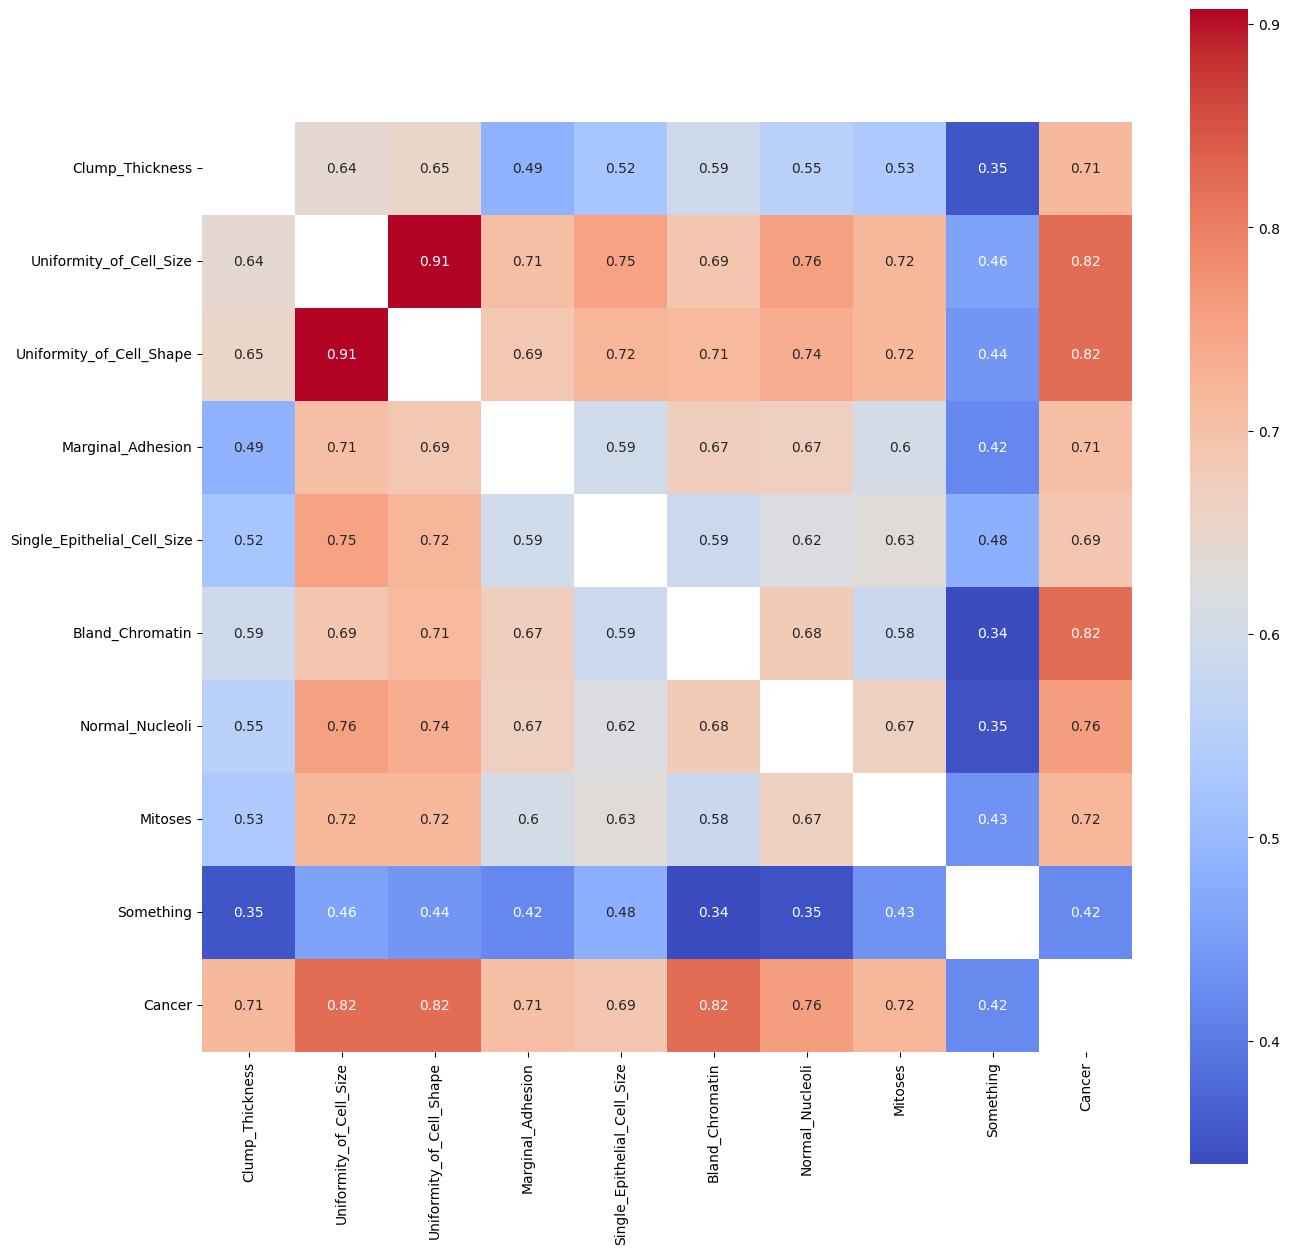

In [10]:
# Plot correlation matrix for feature selection
from scipy.stats import pearsonr
df_corrs = data.corr(numeric_only=True, method='pearson')
pval = data.corr(numeric_only=True, method=lambda X, y: pearsonr(X, y)[1])
ptg_stat_sig = 0.1/100
mask = pval > ptg_stat_sig
plt.subplots(figsize=(15, 15))
heatmap = sns.heatmap(df_corrs, mask = mask, square = True, cmap = 'coolwarm', annot = True)

In [11]:
# Choose "Something" from the predictor list
column_names = column_names[:-1]
X_v2 = data[column_names].values
y_v2 = y

# Train test split
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42)
y_train_v2 = np.squeeze(y_train_v2)

# Cluster the input-output space
cl = Clusterer(x_train=X_train_v2, y_train=y_train_v2, nr_clus=7)
clust_centers_v2, part_matrix_v2, _ = cl.cluster(method='fcm')

# Estimate membership functions parameters
ae_v2 = AntecedentEstimator(X_train_v2, part_matrix_v2)
antecedent_params_v2 = ae_v2.determineMF()

# Estimate consequent parameters
ce_v2 = ConsequentEstimator(X_train_v2, y_train_v2, part_matrix_v2)
conseq_params_v2 = ce_v2.suglms()

In [12]:
modbuilder_v2 = SugenoFISBuilder(antecedent_params_v2, conseq_params_v2, column_names, save_simpful_code=False)
model_v2 = modbuilder_v2.get_model()
modtester_v2 = SugenoFISTester(model_v2, X_test_v2, column_names)
y_pred_probs_v2 = clip(modtester_v2.predict()[0], 0, 1)
y_pred_probs_v2 = column_stack((1 - y_pred_probs_v2, y_pred_probs_v2))
y_pred_v2 = argmax(y_pred_probs_v2,axis=1)

 * Detected 7 rules / clusters
 * Detected Sugeno model type


In [13]:
# %% Compute classification metrics
acc_score_v2 = accuracy_score(y_test_v2, y_pred_v2)
print("Accuracy: {:.3f}".format(acc_score_v2))
rec_score_v2 = recall_score(y_test_v2, y_pred_v2)
print("Recall: {:.3f}".format(rec_score_v2))
prec_score_v2 = precision_score(y_test_v2, y_pred_v2)
print("Precision Score: {:.3f}".format(prec_score_v2))
F1_score_v2 = f1_score(y_test_v2, y_pred_v2)
print("F1-Score: {:.3f}".format(F1_score_v2))
kappa_v2 = cohen_kappa_score(y_test_v2, y_pred_v2)
print("Kappa Score: {:.3f}".format(kappa_v2))

Accuracy: 0.949
Recall: 0.897
Precision Score: 0.981
F1-Score: 0.937
Kappa Score: 0.894
